In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from torch import nn
from torchvision.transforms import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch import device
from torchvision import models
from torch.utils.data import random_split
import torch.nn.functional as F
import seaborn as sns

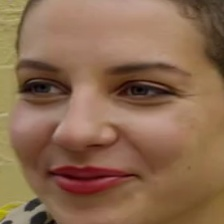

In [3]:
img = Image.open('/content/drive/MyDrive/data/train/fake/01_27__hugging_happy__ZYCZ30C0_0000_01.jpg')
img

In [4]:
img.size

(224, 224)

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

torch.manual_seed(42)

batch_size = 64
trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/data/train', transform=transform)
testset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/data/test', transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [6]:
class DeepfakeDetection(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)  # 32 x 64 x 222 x 222
    self.bn1 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2, 2)   # 32 x 64 x 111 x 111
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)  # 32 x 128 x 109 x 109
    self.bn2 = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(4, 4)
    self.fc1 = nn.Linear(128*13*13, 256)   # After flattening of previous pooling output 16*6*6 comes.
    self.bn3 = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256, 128)
    self.bn4 = nn.BatchNorm1d(128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 1)
    self.relu = nn.ReLU()
    self.dropuot = nn.Dropout(0.5)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.pool2(x)

    x = torch.flatten(x, start_dim=1)

    x = self.fc1(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.dropuot(x)

    x = self.fc2(x)
    x = self.bn4(x)
    x = self.relu(x)
    x = self.dropuot(x)

    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.sigmoid(x)

    return x


In [7]:
model = DeepfakeDetection()

In [8]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def save_checkpoint(model, epoch, optimizer, loss, filepath):
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss
  }, filepath)

In [ ]:
NUM_EPOCHS = 30

In [ ]:
# for epoch in range(1, NUM_EPOCHS+1):
#   for i, data in enumerate(trainloader):
#     inputs, labels = data

#     optimizer.zero_grad()

#     outputs = model(inputs)

#     loss = loss_func(outputs, labels.reshape(-1, 1).float())

#     loss.backward()

#     optimizer.step()

#   if epoch % 3 == 0:
#     save_checkpoint(model, epoch, optimizer, loss, f'/content/drive/MyDrive/ColabNotebooks/deepfake_CNN/checkpoints2/model_epoch_{epoch}.pth')
#     print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 3, Loss: 0.6698784828186035


In [9]:
# When resuming
checkpoint = torch.load('/content/drive/MyDrive/ColabNotebooks/deepfake_CNN/checkpoints2/model_epoch_30.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

In [ ]:
for epoch in range(start_epoch, NUM_EPOCHS+1):
  for i, data in enumerate(trainloader):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, labels.reshape(-1, 1).float())

    loss.backward()

    optimizer.step()

  if epoch % 3 == 0:
    save_checkpoint(model, epoch, optimizer, loss, f'/content/drive/MyDrive/ColabNotebooks/deepfake_CNN/checkpoints2/model_epoch_{epoch}.pth')
    print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 30, Loss: 0.5665232539176941


In [ ]:
y_test = []
y_test_pred = []
for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()

    y_test.extend(y_test_temp.numpy())
    y_test_pred.extend(y_test_hat_temp.numpy())

In [ ]:
acc = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {acc*100:.2f} %')

Accuracy: 54.15 %


In [ ]:
# # Check if your dataset is balanced
# train_real = len(os.listdir('/content/drive/MyDrive/data/train/real'))
# train_fake = len(os.listdir('/content/drive/MyDrive/data/train/fake'))
# test_real = len(os.listdir('/content/drive/MyDrive/data/test/real'))
# test_fake = len(os.listdir('/content/drive/MyDrive/data/test/fake'))

# print(f"Train - Real: {train_real}, Fake: {train_fake}")
# print(f"Test - Real: {test_real}, Fake: {test_fake}")

Train - Real: 7403, Fake: 8987
Test - Real: 1851, Fake: 2247


In [10]:
def evaluate_model(model, testloader, loss_func):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            labels = labels.float()
            outputs = model(images).squeeze()

            # Compute loss
            loss = loss_func(outputs, labels)
            total_loss += loss.item()

            # Predictions
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(testloader)
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=testset.classes))

    return all_labels, all_preds

In [11]:
test_labels, test_preds = evaluate_model(model, testloader, loss_func)


Test Loss: 0.6139
Test Accuracy: 0.5727

Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.25      0.39      2247
        real       0.51      0.97      0.67      1851

    accuracy                           0.57      4098
   macro avg       0.71      0.61      0.53      4098
weighted avg       0.73      0.57      0.52      4098



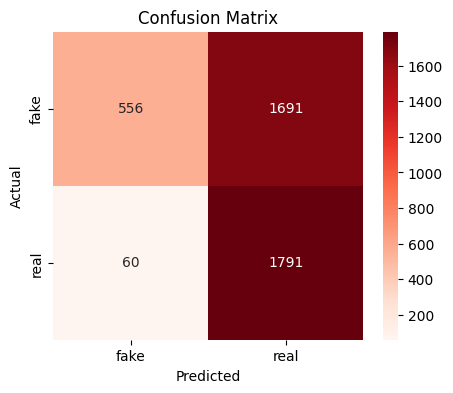

In [12]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=testset.classes, yticklabels=testset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()